In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as ss
from tqdm.auto import tqdm

import requests
import json
from urllib.parse import urlencode

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# считаем данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


groups_url       = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'  
final_groups_url = base_url + urlencode(dict(public_key=groups_url))
response_groups  = requests.get(final_groups_url)
json_groups      = json.loads(response_groups.text)['href']
groups           = pd.read_csv(json_groups, sep=';') # файл с информацией о принадлежности пользователя к контрольной или 
                                                     # экспериментальной группе (А – контроль, B – целевая группа) 

    
groups_add_url       = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'  
final_groups_add_url = base_url + urlencode(dict(public_key=groups_add_url))
response_groups_add  = requests.get(final_groups_add_url)
json_groups_add      = json.loads(response_groups_add.text)['href']
groups_add           = pd.read_csv(json_groups_add) # дополнительный файл с пользователями, 
                                                    # который вам прислали спустя 2 дня после передачи данных

    
active_studs_url       = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'  
final_active_studs_url = base_url + urlencode(dict(public_key=active_studs_url))
response_active_studs  = requests.get(final_active_studs_url)
json_active_studs      = json.loads(response_active_studs.text)['href']
active_studs           = pd.read_csv(json_active_studs) # файл с информацией о пользователях, 
                                                        # которые зашли на платформу в дни проведения эксперимента.

    
checks_url       = 'https://disk.yandex.ru/d/84hTmELphW2sqQ' 
final_checks_url = base_url + urlencode(dict(public_key=checks_url))
response_checks  = requests.get(final_checks_url)
json_checks      = json.loads(response_checks.text)['href']
checks           = pd.read_csv(json_checks, sep=';') # файл с информацией об оплатах пользователей 
                                                     # в дни проведения эксперимента.

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Задание 1. A/B Тестировние
##### Условие
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

##### Входные данные
В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
##### Вопросы
Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

##### Требования к ответу
При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.



### 1.1 Посмотрим что есть в таблицах, изучим данные

##### 1.1.1 Начнем с groups

In [3]:
display(groups.head())
print(
    groups.info(),
    
    f'{groups.id.nunique()} - groups unique id',
    
    f'''{groups.query('grp == "A"').id.nunique()} - unique id grp A''',
    
    f'''{groups.query('grp == "B"').id.nunique()} - unique id grp B''',
    
    f'{groups.id.duplicated().sum()} - duplicated id',
    
    sep='\n\n-------\n\n'
)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None

-------

74484 - groups unique id

-------

14671 - unique id grp A

-------

59813 - unique id grp B

-------

0 - duplicated id


##### Вывод:
    - Все данные в нужном формате, дубликатов, пропусков нету
    - На первый взгляд группы поделены не совсем ровно, по количеству присутствующих в ней человек.
      Тут зависит все от уверенности в том, что система сплитования работает корректно.
      Мы же как хорошая команда предварительно позаботились о ее проверке, так что все ок.

##### 1.1.2 Таблица с пользователями

In [4]:
display(active_studs.head())
print(    
    active_studs.info(),
    
    f'{active_studs.student_id.duplicated().sum()} - duplicated student id',
    
    sep='\n\n-------\n\n'
)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None

-------

0 - duplicated student id


##### Вывод:
    - тут все ок

##### 1.1.3 Дополнительный файл с пользователями

In [5]:
display(groups_add.head())
print(   
    groups_add.info(),
    
    f'''{groups_add.query('grp == "A"').id.nunique()} - unique id grp A''',
    
    f'''{groups_add.query('grp == "B"').id.nunique()} - unique id grp A''',
    
    f'{groups_add.id.duplicated().sum()} - duplicated student id',
    
    sep='\n\n-------\n\n'
)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None

-------

22 - unique id grp A

-------

70 - unique id grp A

-------

0 - duplicated student id


##### Вывод:
    - тут все ок

##### Рекомендации:
    - выяснить, почему часть данных принесена только через два дня.

##### 1.1.4 Файл с информацией об оплатах

In [6]:
display(checks.head())
print(    
    checks.info(),
    
    f'{checks.student_id.duplicated().sum()} - duplicated student id',
    
    f'describe statistics \n{checks.rev.describe()}',
    
    sep='\n\n-------\n\n'
)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None

-------

0 - duplicated student id

-------

describe statistics 
count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64


##### Вывод:
    - тут нас тоже все устраивает

##### 1.1.5 Продолжим и подготовим данные для дальнейшего изучения

In [7]:
# переименуем столбцы для удобного джоина

groups.rename(columns={'id':'student_id'}, inplace=True)
groups_add.rename(columns={'id':'student_id'}, inplace=True)

In [8]:
# объеденим таблицы с данными о группах

groups_full = pd.concat([groups, groups_add], ignore_index=True, axis=0)
groups_full.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
print(
    f'{groups.shape[0] + groups_add.shape[0]} - shape groups + groups add',
    
    f'{groups_full.shape} - groups full shape',
    
    f'{groups_full.student_id.duplicated().sum()} - duplicated id',
    
    sep='\n\n-------\n\n'
)

74576 - shape groups + groups add

-------

(74576, 2) - groups full shape

-------

0 - duplicated id


In [10]:
# Добавим информацию о покупках

groups_full = groups_full.merge(checks, how='left', on='student_id')
groups_full.shape

(74576, 3)

In [11]:
groups_full.head()

,student_id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


In [12]:
# делаем столбец с теми кто был активен

active_studs['active'] = 1

# Получаем таблицу со всеми данными что у нас есть

groups_all = groups_full.merge(active_studs, how='left', on='student_id')

In [13]:
groups_all.head()

,student_id,grp,rev,active
0,1489,B,NaN,NaN
1,1627,A,990.0,1.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [14]:
groups_all.isna().sum()

student_id        0
grp               0
rev           74035
active        66235
dtype: int64

In [15]:
# проверка дубликатов

groups_all.student_id.duplicated().sum()

0

In [16]:
# Проверяем не пересекаются ли группы по студентам

countGroups = groups_all.groupby('student_id')['grp'].nunique()
countGroups.unique()

array([1])

In [17]:
# Заполняем ячейки со значениями нан нулями для удобства работы

groups_all.fillna(0, inplace=True)
groups_all.head()

,student_id,grp,rev,active
0,1489,B,0.0,0.0
1,1627,A,990.0,1.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [18]:
# посмотрим на группу пользователей, файл с которыми нам принесли спустя два дня

In [19]:
added_id = groups_add.merge(checks, how='left')
added_id = added_id.merge(active_studs, how='left')

In [20]:
added_id.fillna(0, inplace=True)

In [21]:
# пользователи которые покупали

added_id.query('rev != 0')

,student_id,grp,rev,active
55,5740903,B,1900.0,1.0


In [22]:
# пользователи которые были активны
added_id.query('active != 0')

,student_id,grp,rev,active
7,5700613,B,0.0,1.0
39,5723133,A,0.0,1.0
40,5723648,B,0.0,1.0
43,5728431,B,0.0,1.0
44,5729371,A,0.0,1.0
49,5730382,B,0.0,1.0
54,5739944,B,0.0,1.0
55,5740903,B,1900.0,1.0
59,5760471,B,0.0,1.0
61,5777081,B,0.0,1.0


In [23]:
# ну что еще, посмотрим идишники пользователей

groups.sort_values('student_id', ascending=False).head(10)

,student_id,grp
74483,5694419,B
74482,5693667,B
74481,5692865,B
74480,5692572,B
74479,5692459,B
74478,5692087,B
74477,5692065,A
74476,5691704,B
74475,5691549,B
74474,5691168,B


In [24]:
# в добавленном файле, большинство id шли более менее по порядку, но присутствуют и такие вот номера

added_id.query('student_id > 6000000')

,student_id,grp,rev,active
81,101067612,B,0.0,0.0
82,200247805,B,0.0,0.0
83,200247808,A,0.0,0.0
84,200247809,A,0.0,0.0
85,200247814,A,0.0,0.0
86,200247816,B,0.0,0.0
87,200247820,B,0.0,0.0
88,201032527,B,0.0,0.0
89,201067612,B,0.0,0.0
90,201067653,B,0.0,0.0


In [25]:
# посмотрим на последние айдишники в таблице с покупками

checks.sort_values('student_id', ascending=False).head()

,student_id,rev
540,5740903,1900.0
539,5681918,1900.0
538,5662322,1900.0
537,5651566,1900.0
536,5645737,1900.0


In [26]:
# посмотрим на последние айдишники в таблице с активными студентами

active_studs.sort_values('student_id', ascending=False).head()

,student_id,active
111,5951797,1
3830,5945085,1
7668,5870856,1
5746,5777081,1
7505,5760471,1


##### Вывод:
    - дубликатов нет, группы не пересекаются, все ок
    - вся информация по добавленым пользователям вполне адекватная. Только есть пользователи id которых, видно что идут с
      номерами далеко отличающихся от основной группы.

##### Рекомендации:
    - Из данных которые принесли через 2 дня , можно вынести догадки, что часть данных которая должна быть, отсутствует. 
      Это обязательно надо проверить. Иначе весь эксперимент на смарку. И дальнейшие действия по эксперименту могут 
      привести к не хорошим последствиям.

##### 1.1.6 Продолжаем изучать данные

In [27]:
# Посмотрим что с пользователями, которые не были активны в дни эксперимента, зададимся вопросом
# Нужны ли они вообще нам для оценки результатов эксперимента?

non_active = groups_all[groups_all['active'] < 1]

In [28]:
non_active.describe()

,student_id,rev,active
count,6.623500e+04,66235.000000,66235.0
mean,2.129987e+06,1.593297,0.0
std,2.902677e+06,38.031788,0.0
min,1.489000e+03,0.000000,0.0
25%,8.637525e+05,0.000000,0.0
50%,1.635302e+06,0.000000,0.0
75%,3.279154e+06,0.000000,0.0
max,2.010677e+08,1980.000000,0.0


In [29]:
# Похоже что это могли быть подписки с автоплатежами
# Работая в компании, мы в принципе должны знать продукт и что у нас есть подписка и автоплатежи

non_active[non_active['rev']>0].groupby('rev').nunique()

,student_id,grp,active
rev,,,
199.0000,14,2,1
290.0000,24,2,1
398.0000,2,2,1
580.0000,4,1,1
630.0000,1,1,1
690.0000,61,2,1
840.0000,3,1,1
990.0000,19,2,1
1140.0000,14,2,1


In [30]:
# таких 149 человек

non_active[non_active['rev']>0].shape[0]

149

In [31]:
# для работы нам понадобятся пользователи которые были активны в дни эксперимента

data = groups_all[groups_all['active']== 1]
data = data[['student_id','grp','rev']]
data.head()

,student_id,grp,rev
1,1627,A,990.0
10,2085,B,0.0
12,2215,B,0.0
43,3391,A,0.0
45,3401,B,0.0


##### Вывод:
    - 149 человек, которые не вошли в таблицу с активными пользователями, вероятнее всего это подписка с автоплатежами.
      Эти данные нам не подходят для нашего эксперимента, так как мы тестируем новую механику оплаты на сайте, из расчетов
      мы их исключаем. Этот вопрос решается на стадии дизайна эксперимента, и данные по автоплатежам не желательно включать
      в данные по эксперименту.
    - В принципе, это могли быть и сбои при сборе данных. К примеру мы точно знаем что у нас нету подписки с автоплатежами.
      Придется в таком случае выяснять что произошло и почему так.

##### 1.1.7 Давайте проведем предварительный анализ данных, распределения, описательные статистики

In [32]:
# Посмотрим на размер групп
# посмотрим на их описательные статитстики

data_a = data[data['grp']=='A'].query('rev > 0')
data_b = data[data['grp']=='B'].query('rev > 0')

print(
    f'{data_a.shape} - grp a shape',
    
    f'{data_b.shape} - grp b shape',
    
    f'describe statistics \n{data_a.rev.describe()}', 
    
    f'describe statistics \n{data_b.rev.describe()}', 
    
    f'{data_a.rev.var()} - var grp a',
    
    f'{data_b.rev.var()} - var grp b',
    
    sep='\n\n-------\n\n'
)

(78, 3) - grp a shape

-------

(314, 3) - grp b shape

-------

describe statistics 
count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

-------

describe statistics 
count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

-------

846276.1931401931 - var grp a

-------

625466.2680387263 - var grp b


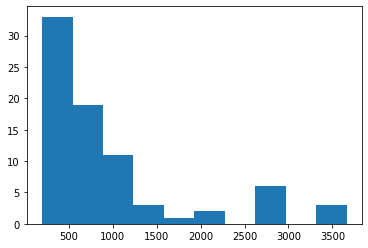

In [33]:
# посмотрим распределения

plt.hist(data_a.rev);

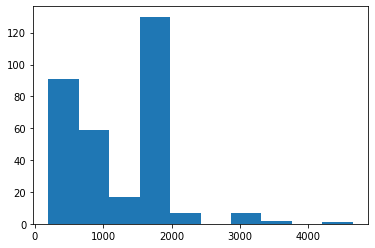

In [34]:
plt.hist(data_b.rev);

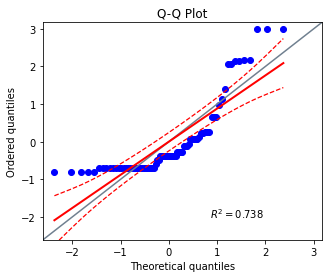

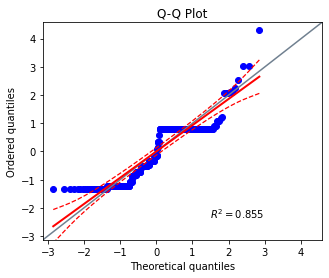

In [35]:
# посмотрим на графики qqplot наших выборок

pg.qqplot(data_a.rev)
pg.qqplot(data_b.rev);

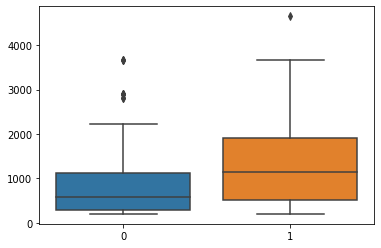

In [36]:
# посмотрим выбросы

sns.boxplot(data=(data_a.rev, data_b.rev));

In [37]:
data_a.query('rev > 2500')

,student_id,grp,rev
6328,332387,A,2910.0
7071,347455,A,2820.0
9916,445767,A,3660.0
13446,594228,A,2900.0
26284,1202202,A,2910.0
36243,1624158,A,3660.0
44395,2150601,A,3660.0
47154,2455897,A,2820.0
62234,4002619,A,2890.0


In [38]:
data_b.query('rev > 4000')

,student_id,grp,rev
38102,1711305,B,4650.0


In [39]:
# посмотрим суммы покупок и их количество в табличном виде
# преобладают покупки суммой 290, вполне возможно что это какой то популярный продукт

data_a.groupby('rev', as_index=False).nunique()

,rev,student_id,grp
0,199.0,5,1
1,290.0,25,1
2,398.0,1,1
3,489.0,2,1
4,580.0,6,1
5,590.0,5,1
6,690.0,4,1
7,840.0,3,1
8,870.0,1,1
9,990.0,5,1


In [40]:
# тут не все так однозначно, очень большое количество покупок суммой 1900
# обязательно нужно просмотреть этот вопрос детально, и выяснить природу этой ситуации

data_b.groupby('rev', as_index=False).nunique()

,rev,student_id,grp
0,199.0000,27,1
1,290.0000,45,1
2,398.0000,6,1
3,489.0000,1,1
4,580.0000,5,1
5,590.0000,6,1
6,597.0000,1,1
7,690.0000,13,1
8,796.0000,1,1
9,840.0000,21,1


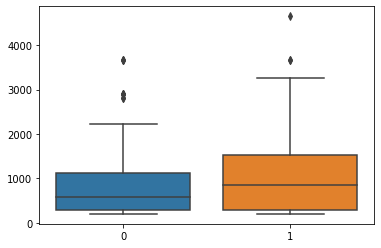

In [41]:
# нужно посмотреть на группы без аномалии со значениями 1900, которые занимают почти треть данных контрольной группы

sns.boxplot(data=(data_a.rev, data_b.query('rev != 1900').rev));

##### Вывод:
    - На боксплоте видно что наши выборки различаются
    - Выборки имеют не нормальное распределение. Имеются выбросы, и в группе "A" они имеют довольно существенное 
      количество наблюдений относительно всей группы. 
    - Т-тест чувствителен к выбросам, малое количество наблюдений, распределение не нормальное, дисбаланс выборок,
      можно посмотреть гомоскедастичность выборок, но опять же желательно в таком случае избавится от выбросов.
      Т-тест мы не будем использовать.
    - Можно углубится в изучение выбросов, и понять что за услуги такие мы оказываем на такие большие суммы, и понять 
      природу этих выбросов. Потом только окончательно принимать решение убирать их или нет.
      На боксплоте видно что выбросы группы А лежат у максимумов группы B и что для группы А является выбросами, 
      то для группы B такие значения лежат в полутораквантильном интервале.
      Поэтому, мы не будем избавлятся от выбросов.
    - Критерий Манна Уитни сложен в интерпритации результатов, а так же чувствителен к дисбалансу выборок, и думаю что как 
      универсальный инструмент, будем использовать бутстрап.
    - В группе B есть значения покупок в 1900 и 1900.0001 и их большое количество, относительно всей группы. Этот вопрос
      довольно важен, и может сильно повлиять на результат эксперимента.
     
      
##### Рекомендации: 
    - Обязательно изучить аномалию с покупками 1900 и 1900.0001

### 1.2 Определение гипотез, расчет метрик, использование стат методов для проверки

##### 1.2.1 Давайте подкрепим наши выводы применением стат метода

У нас получается, что дубликатов по student_id не было, и скорее всего в таблицах доход пользователя. Само название колонки говорит нам об этом. 
Так что для сравнения берем средние значение покупок пользователей

Будем использовать bootstrap.\
Определим порог p-value в 0.05. \
Мы устанавливаем порог уровня значимости таким, потому что, в данном случае результат отклонения нулевой гипотезы нас будет устраивать, если вероятность допустить ошибку первого рода будет меньше 5%

In [42]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
           
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= ci.iloc[0][0] or abs(bar.get_x()) >= ci.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=100,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Определим гипотезы:

    Н0 - отсутствие различий между средними значениями покупок пользователя
    Н1 - различия между средними значениями покупок пользователей есть

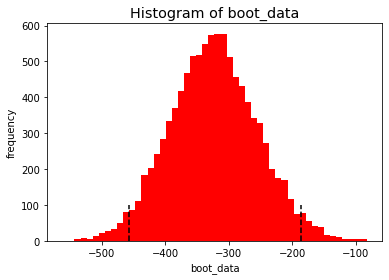

In [43]:
bootstraped_data = get_bootstrap(
    data_a.rev, 
    data_b.rev, 
    boot_it = 10000, 
    statistic = np.mean
);# в результате хранится массив разностей средних, ДИ и pvalue

Как видим на графике, распределение наших выборок стремится к нормальному. Так же, в доверительный интервал не входит 0.

In [44]:
# посмотрим ДИ

print(bootstraped_data['ci'], end='\n\n')

# p-value сильно меньше порогового значения в 0.05. 
# Вероятность допустить ошибку первого рода крайне мала

print(f"p-value = {bootstraped_data['p_value']}")

# что позволяет нам отклонить нулевую гипотезу об отсутствии различий средних значений

                0
0.025 -456.444199
0.975 -185.346667

p-value = 2.421759670945782e-06


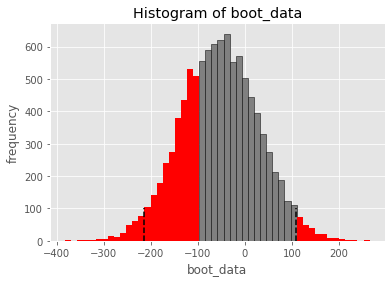

In [45]:
# проведем бутстреп без аномальных значений 1900

bootstraped_data = get_bootstrap(
    data_a.rev, 
    data_b.query('rev != 1900').rev, 
    boot_it = 10000, 
    statistic = np.mean
)# в результате хранится массив разностей средних, ДИ и pvalue

In [46]:
print(f"p-value= {bootstraped_data['p_value']}", end='\n\n')
print(bootstraped_data['ci'])

# без большого количества данных со значениями в 1900, как я и ожидал, мы не можем отклонить H0
# потому что p_value > 0.05 и ноль входит в доверительный интервал

p-value= 0.5103946527093943

                0
0.025 -214.392779
0.975  107.610281


In [47]:
# Теперь, посмотрим как изменилась метрика ARPPU в группах за время проведения эксперимента

print(f'ARPPU контрольной группы за время проведения эксперимента составило \
    {round(data_a.rev.mean(), 2)}'
)

print(f'ARPPU тестовой группы за время проведения эксперимента составило \
    {round(data_b.rev.mean(), 2)}'
)

print(f'Увеличение ARPPU на \
    {round(data_b.rev.mean() - data_a.rev.mean(), 2)} или на \
    {round((data_b.rev.mean() - data_a.rev.mean())/data_a.rev.mean() * 100, 2)}%'
)

ARPPU контрольной группы за время проведения эксперимента составило     933.59
ARPPU тестовой группы за время проведения эксперимента составило     1257.88
Увеличение ARPPU на     324.29 или на     34.74%


In [48]:
# И тоже самое сделаем для выборки без аномалии

print(f'ARPPU контрольной группы за время проведения эксперимента составило \
    {round(data_a.rev.mean(), 2)}'
)

print(f'ARPPU тестовой группы за время проведения эксперимента составило \
    {round(data_b.query("rev != 1900").rev.mean(), 2)}'
)

print(f'Увеличение ARPPU на \
    {round(data_b.query("rev != 1900").rev.mean() - data_a.rev.mean(), 2)} или на \
    {round((data_b.query("rev != 1900").rev.mean() - data_a.rev.mean())/data_a.rev.mean() * 100, 2)}%'
)

ARPPU контрольной группы за время проведения эксперимента составило     933.59
ARPPU тестовой группы за время проведения эксперимента составило     987.67
Увеличение ARPPU на     54.08 или на     5.79%


##### Выводы:
    - Мы не можем просто так выкинуть треть данных, поэтому без ясности вопроса об аномалии, останавливаемся на том, что мы
      отклоняем нулевую гипотезу о равенстве средних.
    - Мы статистически доказали, что средние покупки активных пользователей наших групп имеют различия.
    - При введении новой механики оплаты, мы ожидаем рост среднего дохода на платящего пользователя
    
##### Размышления:
    - Все таки мы тестируем новую механику оплаты, увеличение среднего дохода на платящего пользователя это конечно хорошо, 
      но нас скорее больше бы интересовало бы увеличение конверсии в покупку.

##### 1.2.2 Посмотрим что у нас с конверсией в покупку

In [49]:
groups_all.head()

,student_id,grp,rev,active
0,1489,B,0.0,0.0
1,1627,A,990.0,1.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [50]:
# посчитаем конверсию в покупку

CR_A = round(
        len(groups_all[groups_all['grp']=="A"].query('rev > 0 and active == 1').rev) / 
        len(groups_all[groups_all['grp']=="A"].query('active == 1')) * 100, 
        2
)

CR_B = round(
        len(groups_all[groups_all['grp']=="B"].query('rev > 0 and active == 1').rev) / 
        len(groups_all[groups_all['grp']=="B"].query('active == 1')) * 100, 
        2
)

print(f' Конверсия в покупку группы А {CR_A}%\n Конверсия в покупку группы В {CR_B}%')

 Конверсия в покупку группы А 5.07%
 Конверсия в покупку группы В 4.62%


In [51]:
# Контрольноая группа меньше тестовой примерно в 4 раза

(
    len(groups_all[groups_all['grp']=="B"].query('active == 1')) / 
    len(groups_all[groups_all['grp']=="A"].query('active == 1'))
)

4.423276983094929

Мы видим что конверсия снизилась. Нужно проверить вазимосвязи между группами и покупками

In [52]:
groups_all.head()

,student_id,grp,rev,active
0,1489,B,0.0,0.0
1,1627,A,990.0,1.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [53]:
# добавим столбец, со значениями: купил, не купил

groups_all['buy'] = groups_all.rev > 0
groups_all.head()

,student_id,grp,rev,active,buy
0,1489,B,0.0,0.0,False
1,1627,A,990.0,1.0,True
2,1768,B,0.0,0.0,False
3,1783,B,0.0,0.0,False
4,1794,A,0.0,0.0,False


In [54]:
# подготовим данные для построения кросс таблицы

df_chi2 = groups_all[groups_all['active'] == 1]
df_chi2.head()

,student_id,grp,rev,active,buy
1,1627,A,990.0,1.0,True
10,2085,B,0.0,1.0,False
12,2215,B,0.0,1.0,False
43,3391,A,0.0,1.0,False
45,3401,B,0.0,1.0,False


In [55]:
# построем кросс таблицу

crosstabUsers = pd.crosstab(df_chi2.grp, df_chi2.buy)
crosstabUsers

buy,False,True
grp,,
A,1460,78
B,6489,314


Определим гипотезы:
H0 - Взаимосвязи между группами и совершенными покупками нет
H1 - Взаимсвязь между группами и совершенными покупками есть

In [56]:
# используем хи квадрат для проверки гипотез

stat, p, dof, expected = ss.chi2_contingency(crosstabUsers)
stat, p

(0.48480826522557896, 0.48625240457231045)

p-value больше порогового значения 0.05, взаимосвязи между группами и совершенными покупками нет.

##### Вывод:
    - Мы не можем отклонить нулевую гипотезу, значит мы не можем быть уверены что изменения произошли не случайно.
      
##### Размышления:
    - Мы можем сравнить еще ARPU, что бы внести больше ясности в результат, для этого нам понадобятся выборки со 
      всеми активными пользователями

##### 1.2.3 Сравним ARPU

In [57]:
df_arpu = groups_all.query('active == 1')
df_arpu = df_arpu[['student_id', 'grp', 'rev']]
df_arpu.head()

,student_id,grp,rev
1,1627,A,990.0
10,2085,B,0.0
12,2215,B,0.0
43,3391,A,0.0
45,3401,B,0.0


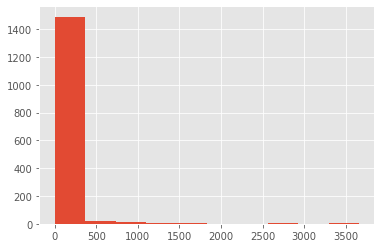

In [58]:
# Посмотрим гистограммы

df_arpu[df_arpu['grp'] == "A"].rev.hist();

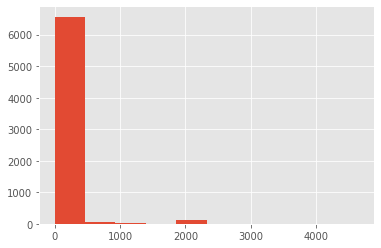

In [59]:
df_arpu[df_arpu['grp'] == "B"].rev.hist();

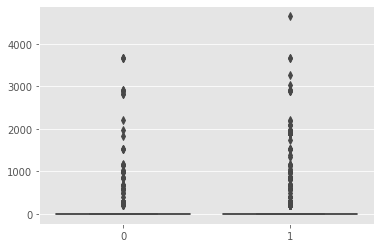

In [60]:
# посмотрим бокс плот

sns.boxplot(data=(df_arpu[df_arpu['grp'] == "A"].rev, df_arpu[df_arpu['grp'] == "B"].rev));

Ну как и ожидалось преобладают нулевые значения и их много

In [61]:
# посмотрим описательные статистики

df_arpu[df_arpu['grp'] == "A"].rev.describe()

count    1538.000000
mean       47.347204
std       290.490632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [62]:
df_arpu[df_arpu['grp'] == "B"].rev.describe()

count    6803.000000
mean       58.058798
std       313.770201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

Видим что изменения есть, они не большие, применять будем бутстрап. Посмотрим сможем ли мы поймать тут различия средних значений в группах.

Сформулируем гипотезы:\
H0 - отсутствие различий в группах\
H1 - срадние наших групп имеют различия

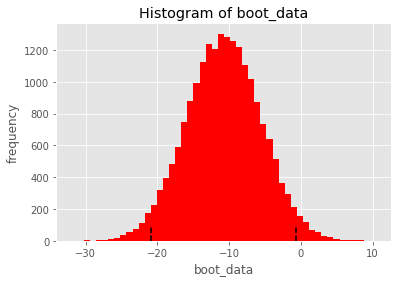

In [63]:
# Возьмем больше бутстрапированных подвыборок для более точной оценки

bootstraped_data = get_bootstrap(
    df_arpu[df_arpu['grp'] == "A"].rev, 
    df_arpu[df_arpu['grp'] == "B"].rev, 
    boot_it = 20000, 
    statistic = np.mean
)# в результате хранится массив разности средних, ДИ и pvalue

In [64]:
# ноль не входит в доверительный интервал

bootstraped_data['ci']

,0
0.025,-20.896495
0.975,-0.641056


In [65]:
# p_value меньше 0.05, мы отклоняем нашу нулевую гипотезу о равенстве средних

bootstraped_data['p_value']

0.03789658653390519

In [66]:
a_mean = df_arpu[df_arpu['grp'] == "A"].rev.mean()
b_mean = df_arpu[df_arpu['grp'] == "B"].rev.mean()

In [67]:
# Давайте посмотрим, как изменилась сама метрика ARPU в группах за время проведения эксперимента

print(f'ARPU контрольной группы за время проведения эксперимента составило \
    {round(a_mean, 2)}'
)

print(f'ARPU тестовой группы за время проведения эксперимента составило \
    {round(b_mean, 2)}'
)

print(f'Увеличение ARPU на \
    {round(b_mean - a_mean, 2)} или на {round((b_mean - a_mean)/a_mean * 100, 2)}%'
)

ARPU контрольной группы за время проведения эксперимента составило     47.35
ARPU тестовой группы за время проведения эксперимента составило     58.06
Увеличение ARPU на     10.71 или на 22.62%


##### Вывод:
    - Мы статистически доказали, что средняя выручка на одного пользователя наших групп имеет различия
    - При введении новой механики оплаты, мы ожидаем рост выручки на одного пользователя

### Подведем итоги A/B эксперимента

1.Для нормального заключения по эксперименту, нам не хватает решения нескольких вопросов:

- Нам желательно знать, хорошо ли справляется наша система сплитования и быть уверенным в ее работе. 
- Часть данных нам почему то принесли только через два дня(из трактовки 3 задания понимаем что это нормальный ход вещей, и постоянная процедура, для которой мы будем писать функцию). 
- Так же было замечено, что номера наших пользователей идут более менее рядом и по порядку, но в файле который нам принесли через 2 дня, присутствуют отдаленые значения id студентов. Это наводит на мысль, что часть данных могли отстутствовать и обязательно нужно выяснить в чем тут дело.
- Наши 149 пользователей которые не были активны в дни эксперимента, но все равно имеют покупки, их происхождение тоже нужно выяснять (в нашем случае мы допустили что это автоплатежи)
- В тестовой группе, есть аномальное количество значений на сумму 1900, и значения 1900.0001, этот вопрос тоже нуждается в изучении. Все таки нам нужно иметь максимально репрезентативные выборки для сравнения, и аномальные значения обусловленные чем то другим плохо вписываются в эксперимент.

2.Если считать, что наши вопросы выше, решились благополучным исходом, и мы вполне можем использовать эти данные для проведения эксперимента, то:

- В тестовой группе мы наблюдаем увеличение метрик ARPPU и ARPU.
- Новая механика никак не повлияла на конверсии в покупку

Итог: новую механику стоит запускать на всех пользователей.

### Задание 2. SQL

Все запросы написаны на нашем сервере постгреса в редаше, их структура совпадает с той что в заданиях

##### 2.1 Очень усердные ученики

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

Дана таблица peas:


Атрибут(Тип) - Значение: \
st_id(Int) - ID ученика\
timest(timestamp) - Время решения карточки\
correct(bool) - Правильно ли решена горошина?\
subject(text) - Дисциплина, в которой находится горошина

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Запрос написан на PostgreSQL

In [68]:
"""

SELECT COUNT(DISTINCT a.st_id)

FROM (
     SELECT
         st_id, 
         COUNT(correct) OVER (
                             PARTITION BY st_id                                      -- группируем по st_id
                             ORDER BY timest ASC                                     -- сортируем по времени
                             RANGE BETWEEN '0 hour' PRECEDING AND '1 hour' FOLLOWING -- делаем окно в 1 час
         ) AS peas_per_hour                 -- считаем для каждого окна в 1 час, решеные горошины
        
     FROM peas  
        
     WHERE
         correct = '1'                      -- отбираем только правильно выполненные горошины
         AND
         date_part('year', timest) = '2020' -- берем нужный год
         AND
         date_part('month', timest) = '3'   -- берем нужный месяц
) AS a

WHERE a.peas_per_hour >= 20

"""

"\n\nSELECT COUNT(DISTINCT a.st_id)\n\nFROM (\n     SELECT\n         st_id, \n         COUNT(correct) OVER (\n                             PARTITION BY st_id                                      -- группируем по st_id\n                             ORDER BY timest ASC                                     -- сортируем по времени\n                             RANGE BETWEEN '0 hour' PRECEDING AND '1 hour' FOLLOWING -- делаем окно в 1 час\n         ) AS peas_per_hour                 -- считаем для каждого окна в 1 час, решеные горошины\n        \n     FROM peas  \n        \n     WHERE\n         correct = '1'                      -- отбираем только правильно выполненные горошины\n         AND\n         date_part('year', timest) = '2020' -- берем нужный год\n         AND\n         date_part('month', timest) = '3'   -- берем нужный месяц\n) AS a\n\nWHERE a.peas_per_hour >= 20\n\n"

##### 2.2 Оптимизация воронки

Дана таблицы: peas (см. выше), studs:

Атрибут(тип) - Смысловое значение\
st_id(int) - ID ученика\
test_grp(text) - Метка ученика в данном эксперименте

и checks:

Название атрибута(Тип атрибута) - Смысловое значение\
st_id(int) - ID ученика\
sale_time(timestamp) - Время покупки\
money(int) - Цена, по которой приобрели данный курс\
subject(text) - Дисциплина, на которую приобрели полный доступ

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:\
ARPU\ 
ARPAU \
CR в покупку \
СR активного пользователя в покупку \
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Запрос написан на PostgreSQL

In [69]:
"""

SELECT 
    grp.test_grp as group,
    SUM(payment.money)/COUNT(DISTINCT(grp.st_id)) AS ARPU,
    SUM(payment.money)/COUNT(DISTINCT(lessons.st_id)) AS ARPAU,
    CAST(COUNT(DISTINCT payment.st_id) AS float)/COUNT(DISTINCT grp.st_id)*100 AS CR_to_purchase,
    CAST(COUNT(DISTINCT payment.st_id) AS float)/COUNT(DISTINCT lessons.st_id)*100 CR_active_users_to_purchase,
    CAST(SUM(CASE WHEN payment.subject = 'math' THEN 1 ELSE 0 END) as float) / SUM(CASE WHEN lessons.subject = 'math' THEN 1 ELSE 0 END)*100 AS CR_math

FROM
    (
    SELECT 
        DISTINCT(st_id),
        test_grp
    FROM studs
) AS grp

LEFT JOIN
    (
    SELECT 
        st_id,
        subject
    FROM peas
    GROUP BY 
        st_id, 
        subject
) AS lessons
ON grp.st_id=lessons.st_id

LEFT JOIN
    (
    SELECT
        st_id,
        sum(money) AS money,
        subject
    FROM checks
    GROUP BY 
        st_id, 
        subject
) AS payment
ON grp.st_id=payment.st_id AND lessons.subject=payment.subject
    
GROUP BY grp.test_grp

"""

"\n\nSELECT \n    grp.test_grp as group,\n    SUM(payment.money)/COUNT(DISTINCT(grp.st_id)) AS ARPU,\n    SUM(payment.money)/COUNT(DISTINCT(lessons.st_id)) AS ARPAU,\n    CAST(COUNT(DISTINCT payment.st_id) AS float)/COUNT(DISTINCT grp.st_id)*100 AS CR_to_purchase,\n    CAST(COUNT(DISTINCT payment.st_id) AS float)/COUNT(DISTINCT lessons.st_id)*100 CR_active_users_to_purchase,\n    CAST(SUM(CASE WHEN payment.subject = 'math' THEN 1 ELSE 0 END) as float) / SUM(CASE WHEN lessons.subject = 'math' THEN 1 ELSE 0 END)*100 AS CR_math\n\nFROM\n    (\n    SELECT \n        DISTINCT(st_id),\n        test_grp\n    FROM studs\n) AS grp\n\nLEFT JOIN\n    (\n    SELECT \n        st_id,\n        subject\n    FROM peas\n    GROUP BY \n        st_id, \n        subject\n) AS lessons\nON grp.st_id=lessons.st_id\n\nLEFT JOIN\n    (\n    SELECT\n        st_id,\n        sum(money) AS money,\n        subject\n    FROM checks\n    GROUP BY \n        st_id, \n        subject\n) AS payment\nON grp.st_id=payment.st

### Задание 3. Python

##### Задача
1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Как я понял из задания, вот мы посчитали все метрики из тех данных что у нас есть, и нам приносят через 2 дня файл groups_add, и нужно включить его в расчет

In [68]:
# подготовим итоговый датафрейм к которому будем добавлять фаил groups_add
active_studs.columns = ['id','is_active']

checks.columns = ['id','rev']
checks['paid'] = 1            # делаем тоже самое и тут

groups.columns = ['id','grp']

In [69]:
full_df = (
    groups
        .merge(
            checks,
            on='id',
            how='left'
        )
        .merge(
            active_studs,
            on='id',
            how='left'
        )
        .fillna(0)
)          
full_df.head() 
                    # Соединяем все и получаем готовый датафрейм, к которому будем добавлять файл groups_add

,id,grp,rev,paid,is_active
0,1489,B,0.0,0.0,0.0
1,1627,A,990.0,1.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


##### 3.1 Функция которая добавляет файл groups_add и пересчитывает метрики

Функция fileAdd() будет на вход принимать два параметра, ссылку на яндекс диске с файлом groups_add и итоговый датафрейм(с id, группой(grp), доход(rev), заплатил или нет(paid), был активен или нет(is_active)) к которому нужно добавить информацию. На выходе получаем датафрейм с метриками которые мы считали в первом задании

In [70]:
def fileAdd(groups_add_url, df):
    
    groups_add_url       = groups_add_url
    base_url             = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_groups_add_url = base_url + urlencode(dict(public_key=groups_add_url))
    response_groups_add  = requests.get(final_groups_add_url)
    json_groups_add      = json.loads(response_groups_add.text)['href']
    groups_add           = pd.read_csv(json_groups_add)
    groups_add.columns   = ['id', 'grp']
                                            # Подгрузили датафрейм, привели заголовки в нужный вид
    all_df = (
        groups_add
            .merge(
                checks,
                on='id',
                how='left'
            )
            .merge(
                active_studs,
                on='id',
                how='left'
            )
            .fillna(0)
    )                                      # Соединили все таблички с информацией об активности и покупки                   
    
    
    all_df = (
        pd.concat(
            [df, all_df], 
            ignore_index=True, 
            axis=0
        )                                  
    )                                      # Соединили датафреймы старый и новый
    
    
    all_df.id.drop_duplicates(inplace=True)
                                           # Удалим дубликаты, что бы исключить пересечение групп
    
    
    # Так как мы сравнивали 3 метрики ARPPU, CR в покупку и ARPU то будем считать только их
    
    ARPPU = (
        all_df[all_df['is_active']== 1]
            .query('paid == 1')
            .groupby('grp', as_index=False)
            .rev
            .mean()
            .rev
    ).round(2)
    
    
    CR = (
        all_df
            .query('is_active == 1 and paid == 1')
            .groupby('grp', as_index=False)
            .agg({'id':'nunique'})
            .id
        /
        all_df
            .query('is_active == 1')
            .groupby('grp', as_index=False)
            .agg({'id':'nunique'})
            .id
    ).mul(100).round(2)

    
    ARPU = (
        all_df[all_df['is_active']== 1]
            .groupby('grp', as_index=False)
            .agg({'rev':'mean'})
            .rev
    ).round(2)
                                            # Посчитали метрики в группах
    
    metrics         = pd.DataFrame([ARPPU,CR,ARPU])
    metrics.columns = ['A','B']
    metrics         = metrics.transpose()
    metrics.columns = ['ARPPU','CR_%','ARPU']
                                            # Делаем аккуратный датафрейм и переименуем колонки
    
    return pd.DataFrame(metrics)

Посмотрим как изменилась таблица с метриками, посмотрим что было с метриками до появления файла groups_add и что после добавления информации из файла

In [71]:
ARPPU = (
    full_df[full_df['is_active']== 1]
        .query('paid == 1')
        .groupby('grp', as_index=False)
        .rev
        .mean()
        .rev
).round(2)

CR = (
        (
        full_df
            .query('is_active == 1 and paid == 1')
            .groupby('grp', as_index=False)
            .agg({'id':'nunique'})
            .id
        /
        full_df
            .query('is_active == 1')
            .groupby('grp', as_index=False)
            .agg({'id':'nunique'})
            .id
    )
    .mul(100)
    .round(2)
)

ARPU = (
    full_df[full_df['is_active']== 1]
        .groupby('grp', as_index=False)
        .agg({'rev':'mean'})
        .rev
).round(2)

metrics = pd.DataFrame([ARPPU,CR,ARPU])
metrics.columns = ['A','B']
metrics = metrics.transpose()
metrics.columns = ['ARPPU','CR_%','ARPU']
metrics

# это до

,ARPPU,CR_%,ARPU
A,933.59,5.08,47.44
B,1255.83,4.61,57.86


In [72]:
# это после
metrics = fileAdd('https://disk.yandex.ru/d/3aARY-P9pfaksg', full_df)
metrics

,ARPPU,CR_%,ARPU
A,933.59,5.07,47.35
B,1257.88,4.62,58.06


##### 3.2 Реализуем функцию, которая будет строить графики по получаемым метрикам.

Тут все просто, функция metricsGraph() получает на вход датафрейм с метриками групп ARPPU, CR, ARPU(именно в такой последовательности) по группам тест и контроль, на выходе получаем визуализацию по группам

In [73]:
def metricsGraph(metrics_df):
    
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=3, 
        figsize=(14, 6)
    ) 
                                # Устанавливаем параметры отображения
        
    sns.barplot(
        x=metrics_df.index, 
        y='ARPPU', 
        data=metrics_df, 
        ax=axes[0], 
        palette='seismic'
    )
    axes[0].set(title='ARPPU')
                                # 1 барплот
    
    sns.barplot(
        x=metrics_df.index, 
        y='CR_%', 
        data=metrics_df, 
        ax=axes[1], 
        palette='seismic'
    )
    axes[1].set(title='CR_to_pay')
                                # 2 барплот
    
    sns.barplot(
        x=metrics_df.index, 
        y='ARPU', 
        data=metrics_df, 
        ax=axes[2], 
        palette='seismic'
    )
    axes[2].set(title='ARPU')
                                # 3 барплот
    
    
    return plt.show()

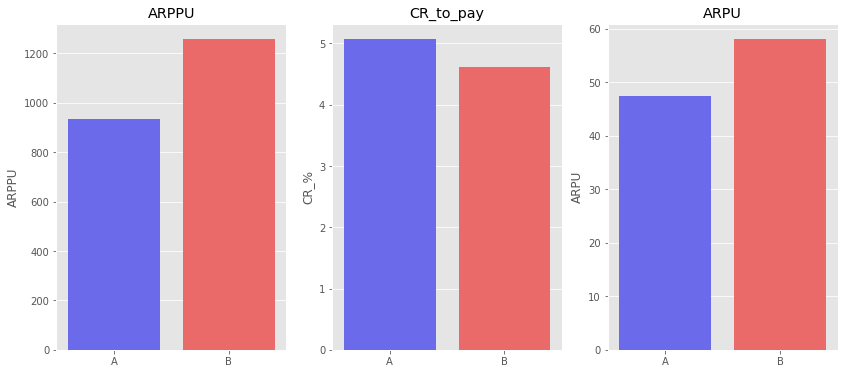

In [74]:
metricsGraph(metrics)